In [23]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
# from utils import PG

In [24]:
image_file = 'baboon.png'

image = Image.open(image_file)
x = np.asarray(image)

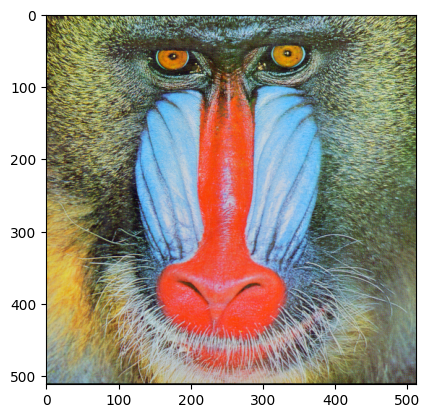

In [25]:
plt.imshow(x)

In [26]:
m = 8;  # downsampling coefficient
y = x[::m, ::m]  # input LR image

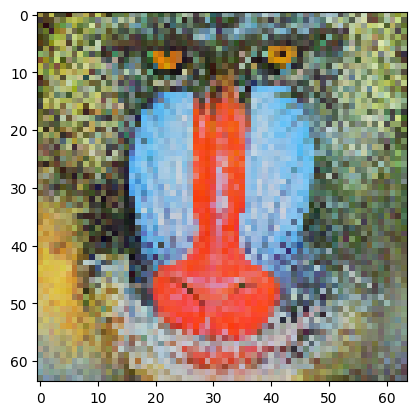

In [27]:
plt.imshow(y)

In [28]:
z = np.zeros(x.shape, dtype=int)
z[::m, ::m] = y

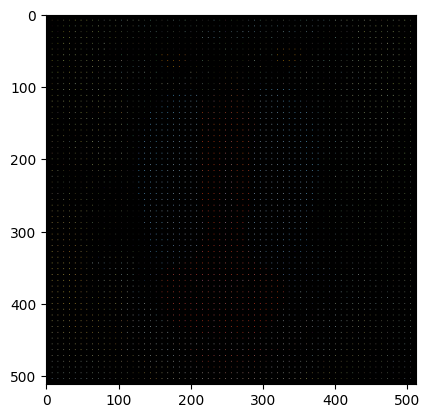

In [29]:
plt.imshow(z)

In [30]:
def lpf(img, ncutoff, m):
    # Apply 2D FFT to the image
    f = np.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = np.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = img.shape
    crow, ccol = rows // m, cols // m
    mask = np.zeros((rows, cols), np.uint8)
    cutoff = int(min(crow, ccol)*ncutoff)
    cv2.circle(mask, (ccol, crow), cutoff, 1, -1)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift * mask

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = np.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = np.fft.ifft2(f_filtered)
    img_filtered = np.real(img_filtered)

    return img_filtered


def pg(input, us_rate, ncutoff, gt_mean, threshold=100):

    pg_mean = 0
    filtered = input

    while pg_mean * 1.1 < gt_mean and threshold > 0:
        filtered = lpf(filtered, ncutoff, 2)
        filtered[::us_rate, ::us_rate] = input[::us_rate, ::us_rate]
        pg_mean = filtered.mean()

        threshold -= 1

    return filtered

In [33]:
pg_image = np.zeros(z.shape, dtype=int)

# Iterate over R, G, B
for i in range(3):
    z_i = z[:,:,i]
    gt_mean_i = x[:,:,i].mean()

    pg_image_i = np.real(pg(z_i, m, 0.2, gt_mean_i, threshold=100))
    
    pg_image[:,:,i] = pg_image_i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


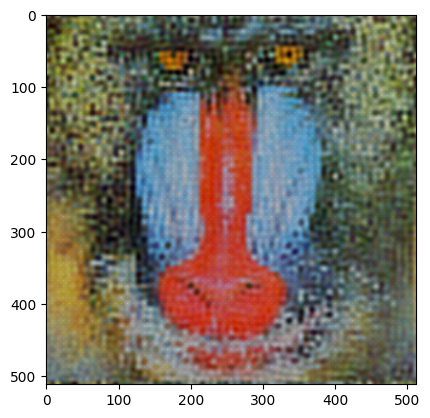

In [34]:
plt.imshow(pg_image)